In [1]:
#================1.retrieve data===========================
import sys
import os
import urllib.request
import getpass
import requests

def verify_datasize(filename, expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found and verified.", filename)
    else:
        raise Exception("Failed to veryfile file [{}], file_size [{}], expected_size [{}].".format(filename, statinfo.st_size, expected_bytes))

        
#Reports every 5% change in download progress
last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100) / totalSize
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
        else:
            sys.stdout.write(".")
        sys.stdout.flush()
    last_percent_reported = percent

    
#download a file from url and check size
data_root = "." #data saved local directory

urls = [['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip', 569918665],
      ['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip',284478493]]
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

def download_data_without_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        urllib.request.urlretrieve(url, dest_filename, download_progress_hook)
        print("\nDownload completed!")
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename

#first you must login to Kaggle, direct to the specific competition, and accept rules competition, or post will direct to rules page.
#eg:dogs-vs-cats's rule page is:https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules
def download_data_with_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        user_name = input("Enter username:")
        pwd = getpass.getpass("Enter password:")
        authen_info = {'UserName':user_name, 'Password': pwd}
        
        #To go to the redirect url
        resp = requests.get(url, headers=headers)
        print("Redirected:", resp.url)

        #To login and get data
        resp = requests.post(resp.url, data = authen_info, headers=headers,stream=True)
        print("Redirected:", resp.url)
        print("Status:", resp.status_code)
        
        if resp.status_code == requests.codes.ok:
            f = open(dest_filename, 'wb')
            for chunk in resp.iter_content(chunk_size = 512 * 1024):# Reads 512KB at a time into memory
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
            f.close()
            print("\nDownload completed!")
        else:
            raise Exception("\nDownload failed")
        
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename
   

train_filename = download_data_with_Authentication(urls[0][0], urls[0][1])
test_filename = download_data_with_Authentication(urls[1][0], urls[1][1])        

    

Found and verified. .\train.zip
Found and verified. .\test.zip


In [5]:
#=================2.unzip file and explore image files======================
import zipfile

def unzip_file(filename):
    file_to_unzip = zipfile.ZipFile(filename)
    file_to_unzip.extractall()
    file_to_unzip.close()
    print("Unzip file succeed.", filename)
    
unzip_file(train_filename)
unzip_file(test_filename)
    

Unzip file {} succeed. .\train.zip
Unzip file {} succeed. .\test.zip


In [16]:
import os
import shutil
from PIL import Image

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]
dirs = [dat_dir, cate_dat_dir, train_dat_dir, valid_dat_dir]

def rebuild_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
    
def prepare_dir(path):
    for dir in dirs:
        rebuild_dir(dir)
        
def rearrange_data(category_name):
    if category_name not in categories:
        raise Exception("\n category [{}] not exists.", category_name)
        
    category_data_dir = cate_dat_dir + "/" + category_name
    rebuild_dir(category_data_dir)
    
    train_filenames = os.listdir('./train')
    train_category = filter(lambda x:x[:3].upper() ==category_name.upper() , train_filenames)
    train_count = 0
    for filename in train_category:
        train_count += 1
        shutil.copy("./train/" + filename, category_data_dir)
    return train_count
 
def get_image_properties(category_name):
    if category_name not in categories:
        raise Exception("\n category {{}] not exists.", category_name)
        
    category_map = {}
    path = cate_dat_dir + "/" + category_name + "/"
    filenames = os.listdir(path)
    for filename in filenames:
        im = Image.open(path + filename)
        category_map[filename] = [im.format, im.mode, im.width, im.height]
    return category_map

#prepare_dir(dirs)    
#dog_counts = rearrange_data("dog")
#cat_counts = rearrange_data("cat")
#image_properties_dog = get_image_properties("dog")
#image_properties_cat = get_image_properties("cat")


dogs count : [12500]. cats count:[12500]

dogs group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64

cats group by format, mode:
format  mode
JPEG    RGB     12500
Name: width, dtype: int64


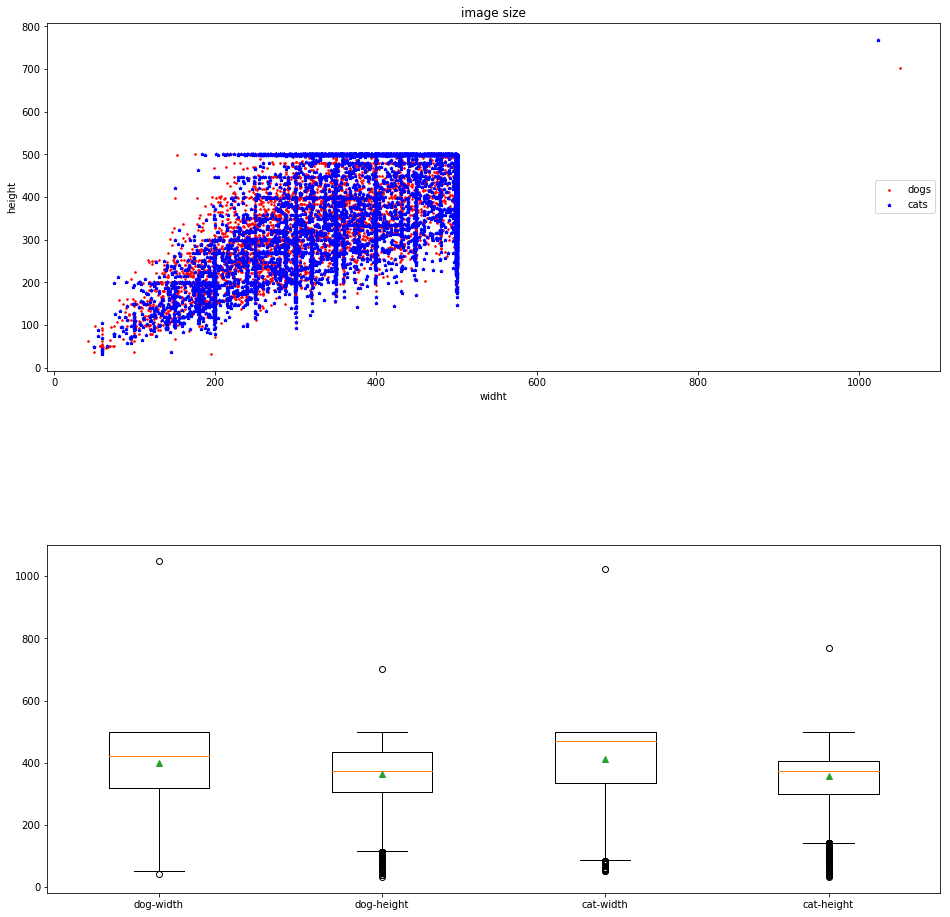


dogs width max/min:
               format mode width height
dog.2317.jpg    JPEG  RGB  1050    702
dog.10733.jpg   JPEG  RGB    42     62

dogs height max/min:
              format mode width height
dog.2317.jpg   JPEG  RGB  1050    702
dog.4367.jpg   JPEG  RGB   195     33

cats width max/mai:
               format mode width height
cat.835.jpg     JPEG  RGB  1023    768
cat.10392.jpg   JPEG  RGB    50     49

cats height max/min:
              format mode width height
cat.835.jpg    JPEG  RGB  1023    768
cat.6402.jpg   JPEG  RGB    60     32


In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

columns = ['format', 'mode', 'width', 'height']

df_dog = pd.DataFrame(image_properties_dog).transpose()
df_cat = pd.DataFrame(image_properties_cat).transpose()
df_dog.columns = columns
df_cat.columns = columns

print("\ndogs count : [{}]. cats count:[{}]".format(dog_counts, cat_counts))

print("\ndogs group by format, mode:")
print(df_dog.groupby(['format', 'mode'])['width'].count())
print("\ncats group by format, mode:")
print(df_cat.groupby(['format', 'mode'])['width'].count())


plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.scatter(x=df_dog['width'], y=df_dog['height'], s=10, marker=".", color='red')
plt.scatter(x=df_cat['width'], y=df_cat['height'], s=10, marker="*", color='blue')
plt.legend(['dogs','cats'], loc='center right')
plt.xlabel('widht')
plt.ylabel('height')
plt.title("image size")
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,2)
plt.boxplot([df_dog['width'], df_dog['height'], df_cat['width'], df_cat['height']], showmeans=True)
plt.xticks([1,2,3,4], ['dog-width', 'dog-height', 'cat-width', 'cat-height'])
#plt.subplots_adjust(hspace = .5)
plt.show()

print("\ndogs width max/min:\n",df_dog.loc[[df_dog['width'].idxmax(),df_dog['width'].idxmin()]])
print("\ndogs height max/min:\n",df_dog.loc[[df_dog['height'].idxmax(),df_dog['height'].idxmin()]])
print("\ncats width max/mai:\n",df_cat.loc[[df_cat['width'].idxmax(),df_cat['width'].idxmin()]])
print("\ncats height max/min:\n",df_cat.loc[[df_cat['height'].idxmax(),df_cat['height'].idxmin()]])

In [18]:
#========================3.split and preprocess data================================
import random

def split_train_valid(category_name, test_percent, random_seed=None):
    if category_name not in categories:
        raise Exception("\n category [{}] note exists.", category_name)
    if test_percent <=0 or test_percent >=1:
        raise Exception("\n test_percent must be in (0,1)")
        
    source_dir = cate_dat_dir + "/" + category_name
    dest_train_dir = train_dat_dir + "/" + category_name
    dest_valid_dir = valid_dat_dir + "/" + category_name
    
    filenames = os.listdir(source_dir)
    total_size = len(filenames)
    test_size = int(total_size * test_percent)
    train_size = total_size - test_size
    
    if not random_seed is None:
        random.seed(random_seed)
    random.shuffle(filenames)
    rebuild_dir(dest_train_dir)
    rebuild_dir(dest_valid_dir)
    for i in range(0, total_size):
        if i < test_size:
            #TODO:link or copy
            shutil.copy(source_dir + "/" + filenames[i], dest_valid_dir)
        else:
            #TODO:link or copy
            shutil.copy(source_dir + "/" + filenames[i], dest_train_dir)
    return train_size, test_size

dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234)


D:\Program_Files\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (50, 50), name="cov1", padding="same", activation="relu", input_shape=(3, 100, 1...)`
D:\Program_Files\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((10, 10), name="pool1", padding="same")`
D:\Program_Files\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (32, 32), name="cov2", padding="same", activation="relu")`
D:\Program_Files\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (10, 10), name="cov3", padding="same", activation="relu")`
D:\Program_Files\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update y

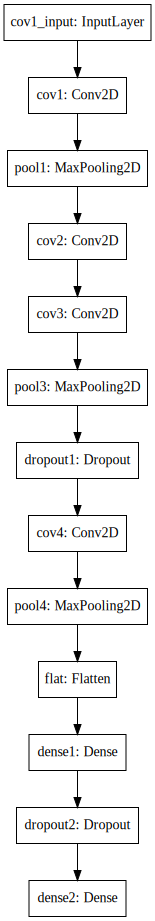

In [27]:
#========================4.create model=========================
from keras.models import Sequential
from keras.layers import *
from keras.utils.vis_utils import plot_model, model_to_dot
#from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import Image, SVG

image_width=100
image_height=100
model1 = Sequential()
model1.add(Convolution2D(32, 50, 50, input_shape=(3, image_width, image_height), activation='relu', border_mode='same', name='cov1'))
model1.add(MaxPooling2D((10,10), border_mode='same', name='pool1'))
model1.add(Convolution2D(128, 32, 32, activation='relu', border_mode='same', name='cov2'))
#model1.add(MaxPooling2D((10,10), border_mode='same', name='pool2'))
model1.add(Convolution2D(512, 10, 10, activation='relu', border_mode='same', name='cov3'))
model1.add(MaxPooling2D((10,10), border_mode='same', name='pool3'))
model1.add(Dropout(0.2, name="dropout1"))
model1.add(Convolution2D(1024, 2, 2, activation='relu', border_mode='same', name='cov4'))
model1.add(MaxPooling2D((10,10), border_mode='same', name='pool4'))
model1.add(Flatten(name='flat'))
model1.add(Dense(64, activation='relu', name='dense1'))
model1.add(Dropout(0.4, name="dropout2"))
model1.add(Dense(1, activation='sigmoid', name='dense2'))
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# visualize model
plot_model(model1, to_file='model1.png', show_shapes=True)
#plot(model1, to_file='model1.png', show_shapes=True)
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [ ]:
#==========================5.train model==========================
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

perbatch =10
total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_size = (image_width,image_height)
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        data_format='channels_first')
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
       train_dat_dir,
       target_size=image_size,
       batch_size = perbatch,
       class_mode='binary')
valid_generator = train_datagen.flow_from_directory(
       valid_dat_dir,
       target_size=image_size,
       batch_size = perbatch,
       class_mode='binary')

history = model1.fit_generator(train_generator,
                samples_per_epoch = total_train_size,
                nb_epoch=10,
                validation_data=valid_generator,
                nb_val_samples=total_valid_size,
                callbacks=[TensorBoard(log_dir='./model1')])

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


D:\Program_Files\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_steps=7500, steps_per_epoch=1750, epochs=10, validation_data=<keras.pre..., callbacks=[<keras.ca...)`


Epoch 1/10
 105/1750 [>.............................] - ETA: 5823s - loss: 8.0964 - acc: 0.4905 

In [ ]:
#================================5.visulize model training log data==========================
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1, 2,1)
# summarize history for accuracy
plt.plot(history.history['dense2_acc'])
plt.plot(history.history['val_dense2_acc'])
plt.title('model accuracy of dense2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='center right')
plt.subplots_adjust(wspace = .5)
    
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['dense2_loss'])
plt.plot(history.history['val_dense2_loss'])
plt.title('model loss of dense2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='center right')
    
plt.show()

In [ ]:
#==============================6.predict test data============================
import pandas as pd

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("./test", image_size, shuffle=False, 
                                              batch_size=perbatch)
test = model.predict_generator(test_generator, test_generator.nb_sample)
df = pd.read_csv("./sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', test[i])

df.to_csv('pred.csv', index=None)
df.head(10)

In [ ]:
#==============================7.save model=================
#import h5py as h5py
try:
    import h5py
except ImportError:
    h5py = None
    
model1.save_weights('model1.h5')
with open('model1.json', 'w') as f:
    f.write(model1.to_json())